<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/14_Multinomial_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="darkblue">Polychotomous (Multi Classification) Data Model

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import numpy as np
import pandas as pd
import statistics as stat
import scipy
import pystan

In [ ]:
#For plots
import arviz as az
import matplotlib.pyplot as plt

#<font color="darkblue"> Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Data Sets/ProgramChoice.csv"
progcho_da = pd.read_csv(path)

In [ ]:
conditions = [
    (progcho_da["prog"]=="academic"),
    (progcho_da["prog"]=="general"),
    (progcho_da["prog"]=="vocation"),]
choices = [1, 2, 3]

progcho_da["prog_c"] = np.select(conditions, choices)

In [ ]:
progcho_da_1=progcho_da.sample(n=100,replace=False)

In [ ]:
progcho_da.head()

,Unnamed: 0,id,female,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid,prog_c
0,1,45,female,low,public,vocation,34,35,41,29,26,not enrolled,0,1,3
1,2,108,male,middle,public,general,34,33,41,36,36,not enrolled,0,1,2
2,3,15,male,high,public,vocation,39,39,44,26,42,not enrolled,0,1,3
3,4,67,male,low,public,vocation,37,37,42,33,32,not enrolled,0,1,3
4,5,153,male,middle,public,vocation,39,31,40,39,51,not enrolled,0,1,3


In [ ]:
progcho_da.columns

In [ ]:
progcho_da.dtypes

In [ ]:
prog_cnt=progcho_da.prog.value_counts()
prog_cnt=pd.DataFrame(prog_cnt)
prog_cnt['sam_prop']=prog_cnt['prog'].apply(lambda x: x/np.sum(prog_cnt.prog))
prog_cnt

,prog,sam_prop
academic,105,0.525
vocation,50,0.250
general,45,0.225


# <font color="darkblue"> Quantity of Interest QoI

Choices for the students to enrol in a program

1. general program

2. vocational program

3. academic program.

**Model: Students' choice using their base scores and SES**

- In this data set, QoI is *prog*, course choice by an applicant

- A polychotomous variable with above three levels

- Interest is to **estimate** the odds of choosing one option compared to a base level from the **sample** data

- This may be done without any predictors as a step to summarize the behaviour of QoI

- However, an explantory model may validate any question / uncertainty about the QoI and associations (if any) with predictors

- As usual, it is better to know the nature of the variable to make appropriate summary measures and modeling procedures

# <font color="darkblue"> Bayesian Model

Assume a polychotomous variable with $k$ levels, and $n_1,n_2, \cdots n_k$ are the counts in each of the $k$ classes

Let $\theta_1,\theta_2, \cdots \theta_k$ be the proportion parameters for the class membership of the population

Two conditions are $\sum n_j = N$, the total counts and $\sum \theta_j = 1$, total probability is one

In symbols,

$$Y \sim \mathrm{Multinomial}(\theta)$$ where $\theta=(\theta_1, \theta_2, \cdots \theta_k)$

$$\theta \sim \mathrm{Dirichlet}(\alpha)$$ where  $\alpha=(\alpha_1, \alpha_2, \cdots \alpha_k)$


### If $\alpha_1=\alpha_2=\cdots=\alpha_k=1$, then resultant Dirichlet is Uniform in k-dimesnion

In [ ]:
mult_model1="""
data {
  int<lower = 1> N;
  int<lower = 2> k;
  int<lower = 0,upper = k> y[N];
  vector<lower=0>[k] a;
}
parameters {
  simplex[k] theta;
}


model{
  y~categorical(theta);
  theta~dirichlet(a);
}
"""

posterior_mod1 = pystan.StanModel(model_code=mult_model1)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b733c552659d5e6676dbedabaae308d NOW.


In [ ]:
# Input - data and values for prior parameters a

n=len(progcho_da)
y1=progcho_da['prog_c']
a1 = np.array([1])
a=np.repeat(a1, [3], axis=0)
progcho_data1 = {'N':n,
             'k':3,
             'a':a,
             'y':y1,
            }
progcho_data1

{'N': 200, 'a': array([1, 1, 1]), 'k': 3, 'y': 0      3
 1      2
 2      3
 3      3
 4      3
       ..
 195    1
 196    3
 197    1
 198    1
 199    1
 Name: prog_c, Length: 200, dtype: int64}

In [ ]:
progcho_mod1_fit1= posterior_mod1.sampling(data=progcho_data1,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
az.plot_trace(progcho_mod1_fit1,compact=False, legend=True)
plt.show()

In [ ]:
summ_mod1=az.summary(progcho_mod1_fit1,round_to=3,hdi_prob=0.95)
summ_mod1

In [ ]:
mult_model2="""
data {
  int<lower = 1> N;
  int<lower = 2> k;
  int<lower = 1,upper = k> y[N];
  vector<lower=0>[k] a;
}
parameters {
  simplex[k] theta;
}
model{
  y~categorical(theta);
  theta~dirichlet(a);
}
generated quantities{
  int<lower = 1,upper = k> pred_y = categorical_rng(theta);
  real<lower=-1,upper=1> th1_the2=theta[1]-theta[2];
  real<lower=-1,upper=1> th1_the3=theta[1]-theta[3];
  real<lower=-1,upper=1> th2_the3=theta[2]-theta[3];
}
"""

posterior_mod2 = pystan.StanModel(model_code=mult_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01109c701bbc9b3a54e6b16bcf37444c NOW.


In [ ]:
progcho_mod2_fit= posterior_mod2.sampling(data=progcho_data1,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

In [ ]:
az.plot_trace(progcho_mod2_fit,compact=False, legend=True,var_names=["theta"])
plt.show()

In [ ]:
summ_mod2=az.summary(progcho_mod2_fit,round_to=3,hdi_prob=0.95)
summ_mod2

In [ ]:
progchoi_mod2_op=az.from_pystan(posterior=progcho_mod2_fit,
                                posterior_predictive=['pred_y'])
progchoi_mod2_op

In [ ]:
df = progchoi_mod2_op.posterior_predictive.pred_y.to_dataframe()
np.mean(df)

In [ ]:
pred_cnt=df.value_counts()
pred_cnt=pd.DataFrame(pred_cnt)
pred_cnt.columns=["Count"]
pred_cnt['Class_prop']=pred_cnt['Count'].apply(lambda x: x/np.sum(pred_cnt.Count))
pred_cnt
#df.value_counts()

,Count,Class_prop
pred_y,,
1.0,14581,0.520750
3.0,7073,0.252607
2.0,6346,0.226643


In [ ]:
mult_fit1="""
data {
  int<lower = 2> K;
  int<lower = 0> N;
  int<lower = 1> D;
  int<lower = 1, upper = K> y[N];
  matrix[N, D] x;
}
parameters {
  matrix[D, K] beta;
}

model {
  matrix[N, K] x_beta = x * beta;

  to_vector(beta) ~ cauchy(0, 2.5); //normal(0, 5);

  for (n in 1:N)
    y[n] ~ categorical_logit(x_beta[n]');
}
"""
posterior_fit1 = pystan.StanModel(model_code=mult_fit1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f76e53e33e811b69370eee5d14ed3ca9 NOW.


In [ ]:
n=len(progcho_da)
y1=progcho_da['prog_c']
a1 = np.array([1])
a=np.repeat(a1, [n], axis=0)
zz=np.asmatrix(a)
zz1=zz.transpose()
progcho_fit1_data = {'N':n,
             'K':3,
             'y':y1,
             'x':zz1,
             'D':1,
            }
progcho_fit1_data

In [ ]:
progcho_fit1= posterior_fit1.sampling(data=progcho_fit1_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

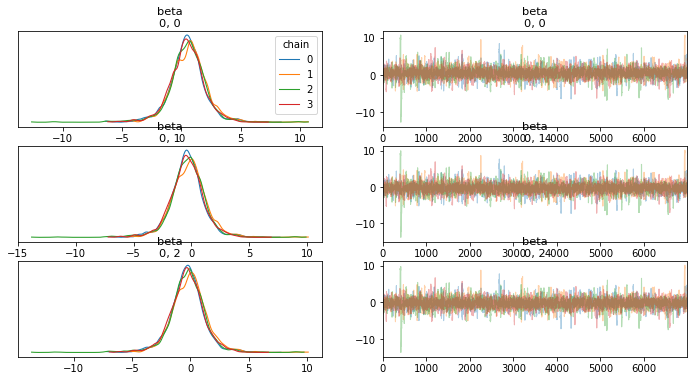

In [ ]:
az.plot_trace(progcho_fit1,compact=False, legend=True,var_names=["beta"])
plt.show()

In [ ]:
summ_fit1=az.summary(progcho_fit1,round_to=3,hdi_prob=0.95)
summ_fit1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.534,1.522,-2.511,3.568,0.029,0.029,2913.883,2713.225,1.003
"beta[0, 1]",-0.315,1.524,-3.383,2.684,0.029,0.029,2939.832,2739.627,1.003
"beta[0, 2]",-0.209,1.524,-3.171,2.899,0.029,0.030,2926.362,2726.731,1.003


In [ ]:
m=scipy.special.softmax(summ_fit1['mean'])
m

beta[0, 0]    0.525341
beta[0, 1]    0.224763
beta[0, 2]    0.249896
Name: mean, dtype: float64

In [ ]:
n=len(progcho_da_1)
y1=progcho_da_1['prog_c']
#a = np.array([1])
#a1=np.repeat(a, [n], axis=0)
a2=progcho_da_1['math']
zz2=np.matrix([a2])
#zz2=np.matrix([a1,a2])
zz3=zz2.transpose()
progcho_fit2_data = {'N':n,
             'y':y1,
             'D':1,
             'x':zz3,
             'K':3
              }
progcho_fit2_data

In [ ]:
progcho_fit2= posterior_fit1.sampling(data=progcho_fit2_data,
                                      iter=10000,
                                      chains=2, seed=1,
                                      warmup=3000, thin=10, control={"max_treedepth":25,"adapt_delta" : 0.9999})

In [ ]:
summ_fit2=az.summary(progcho_fit2,round_to=3,hdi_prob=0.95)
summ_fit2

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.033,1.379,-2.732,2.772,0.051,0.037,771.799,735.8,1.003
"beta[0, 1]",0.011,1.379,-2.859,2.649,0.051,0.037,771.581,735.8,1.003
"beta[0, 2]",0.015,1.379,-2.757,2.745,0.051,0.037,771.627,735.8,1.003


In [ ]:
mult_fit2="""
data {
  int<lower = 2> K;
  int<lower = 0> N;
  int<lower = 1> D;
  int<lower = 1, upper = K> y[N];
  vector[D] x[N];
}
parameters {
  matrix[K, D] beta;
}

model {
  for(j in 1:K)
  beta[j] ~ cauchy(0, 2.5); //normal(0, 5);

  for (n in 1:N)
    y[n] ~ categorical_logit(beta*x[n]);
}
"""
posterior_fit2 = pystan.StanModel(model_code=mult_fit2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36be2ad924120444a553426a5e11ca35 NOW.


In [ ]:
progcho_fit2= posterior_fit2.sampling(data=progcho_fit2_data,
                                      iter=10000,
                                      chains=2, seed=1,
                                      warmup=3000, thin=10, control={"max_treedepth":15,"adapt_delta" : 0.9999})